# COVID metabolite-metabolite network 

In [104]:
!pip install marsilea

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
     |████████████████████████████████| 80 kB 1.3 MB/s 


In [1]:
# from COVID_study_processing import MTBLSDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import libchebipy
import cmcrameri.cm as cmc
import scipy.stats as stats
from matplotlib import pyplot as plt
import marsilea as ma
from marsilea.upset import UpsetData
from marsilea.plotter import Colors, Labels


import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import glob
import sspa
import numbers

sns.set_theme(
    style='whitegrid',
    palette='Paired',
#     font='Arial',
)


In [4]:
# download pathways
reactome_paths = sspa.process_reactome(
    organism='Homo sapiens',
    download_latest=True,
    omics_type='metabolomics',
    filepath='.' # save to current directory
)

Beginning Reactome download...
Reactome DB file saved to ./Reactome_Homo_sapiens_pathways_ChEBI_R89.gmt
Complete!


In [69]:

class MTBLSDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, md_group, md_filter, identifier='database_identifier', remove_suffix=None, remove_prefix=None,  outliers=None, pathway_level=False):
        self.file_path = file_path
        self.raw_data = None
        self.remove_suffix = remove_suffix
        self.remove_prefix = remove_prefix
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None
        self.identifier = identifier
        self.outliers = outliers
        self.pathway_data = None
        self.pathway_level = pathway_level
        self.pathway_coverage = None

        self.read_data()
        # self.preprocess_data()
        self.get_pathway_data()
        self.da_testing()
        

    def read_data(self):
        # check if there are multiple files in folder
        metadata = pd.read_csv(self.file_path + '/s_' + self.id + '.txt', sep = '\t', encoding='unicode_escape')

        metadata['Sample Name'] = metadata['Sample Name'].astype(str)
        if self.remove_suffix:
            metadata['Sample Name'] = metadata['Sample Name'].str[:-self.remove_suffix]
        if self.remove_prefix:
            metadata['Sample Name'] = metadata['Sample Name'].str[self.remove_prefix:]

        self.metadata = metadata

        files = glob.glob(self.file_path + '/*' + 'maf.tsv')
        if len(files) > 1:
            print(len(files), 'assay files found')
            # read in all files and concatenate
            dfs = []
            dfs_proc = []
            for f in files:
                df = pd.read_csv(f, sep='\t')
                dfs.append(df)
                # df.index = df['Samples']
                self.raw_data = df

                df_proc = self.preprocess_data()
                dfs_proc.append(df_proc)

            self.raw_data = pd.concat(dfs, axis=1)
            
            # inner join removes samples not present in all assays
            proc_data = pd.concat(dfs_proc, axis=1, join='inner')
            # aveage same columns
            proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
            # remove duplicate 'Group' columns
            proc_data = proc_data.loc[:, ~proc_data.columns.duplicated()]

            # move group column to end
            cols = [col for col in proc_data.columns if col != 'Group'] + ['Group']
            self.processed_data = proc_data[cols]

        else:
            print(len(files), 'assay file found')
            data = pd.read_csv(files[0], sep='\t')
            # data.index = data['Samples']
            self.raw_data = data

            proc_data = self.preprocess_data()
            proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
            self.processed_data = proc_data

        return self.processed_data, self.metadata


    def preprocess_data(self):
        data_filt = self.raw_data.copy()

        # repalce decimal in mz ratios
        try:
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].round(2)
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].astype('str').apply(lambda x: re.sub(r'\.', '_', x))
        except KeyError:
            pass

        self.all_ids = data_filt.iloc[:, ~data_filt.columns.isin(self.metadata['Sample Name'].tolist())]

        # # make a new identifier colum from chebi and metabolite_identification, prioritise chebi
        # data_filt['Identifier'] = data_filt['database_identifier'].replace('unknown', np.NaN)
        
        # try:
        #     data_filt['Identifier_filled'] = data_filt['Identifier'].fillna(data_filt['mass_to_charge'])
        #     data_filt = data_filt[data_filt['Identifier_filled'].notna()]
        #     data_filt.index = data_filt['Identifier_filled']
        # except KeyError:
        #      data_filt.index = data_filt['Identifier']

        # # set chebi as index
        data_filt = data_filt[data_filt[self.identifier].notna()]
        # drop 'unknown'
        # if there are no chebis in the whole assay file, drop it
        if data_filt.shape[0] == 0:
            print('No CHEBIS for assay')
            return None
        else:
            data_filt = data_filt[data_filt[self.identifier] != 'unknown']
            data_filt.index = data_filt[self.identifier]

            # remove assay specific sample suffixes
            if self.remove_suffix:
                data_filt.columns = data_filt.columns.str[:-self.remove_suffix]

            # keep only abundance data filtering on samples
            # store alternative identifiers in a dict
            samples = self.metadata['Sample Name'].tolist()
            ids = data_filt.iloc[:, ~data_filt.columns.isin(samples)]
            self.id_dict = ids.to_dict()
            data_filt = data_filt.iloc[:, data_filt.columns.isin(samples)]


            # ensure all data is numeric
            data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

            # Transpose
            data_filt = data_filt.T

            # There will be QC samples so better filter on metadata at this point
            md_dict = dict(zip(self.metadata['Sample Name'], self.metadata[self.md_group]))
            # add metadata column
            data_filt['Group'] = data_filt.index.map(md_dict)

            # filter on metadata
            data_filt = data_filt[data_filt['Group'].isin(self.md_filter.values())]
            data_filt = data_filt.drop(columns=['Group'])
            # drop outliers
            if self.outliers:
                data_filt = data_filt.drop(self.outliers)

            # Missingness checks 
            # replace empty strings with NaN
            data_filt = data_filt.replace(['', ' '], np.nan)
            # Delete colums and rows where all values are missing
            data_filt = data_filt.dropna(axis=0, how='all')
            data_filt = data_filt.dropna(axis=1, how='all')

            # Delete rows and columns where all values are 0 
            data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
            data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

            data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
            missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
            print(f"Missingness: {missing_pct:.2f}%")

            # impute missing values
            imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
            data_imputed = imputer.fit_transform(data_filt)

            # log transformation
            data_imputed = np.log(data_imputed + 1)

            # standardize
            scaler = StandardScaler().set_output(transform="pandas")
            data_scaled = scaler.fit_transform(data_imputed)

            data_scaled['Group'] = data_scaled.index.map(md_dict)
            self.processed_data = data_scaled

            return data_scaled
    
    def get_pathway_data(self):
        reactome_paths = sspa.process_gmt(infile='Reactome_Homo_sapiens_pathways_ChEBI_R89.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        # remove CHEBI: from column names
        data = self.processed_data
        data.columns = data.columns.str.removeprefix("CHEBI:")

        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
    
    def plot_qc(self):
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # every nth feature - display 20 features
        feature_idx = int(self.processed_data.shape[1]/20)
        filt_features = self.processed_data.iloc[:, ::feature_idx]
        filt_features['Group'] = self.processed_data['Group']
        data_long = filt_features.melt(id_vars='Group')
        sns.boxplot(data=data_long, ax=ax2, hue='Group', x='variable', y='value')
        ax2.tick_params(axis='x', rotation=90)
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()

    def da_testing(self):

        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]


In [32]:
# MTBLS2224
s2224 = MTBLSDataset(
    file_path = 'Studies/MTBLS2224', 
    id = 'MTBLS2224', 
    node_name = 'MTBLS2224', 
    md_group = 'Factor Value[COVID Infection]', 
    md_filter = {'Case': 'Positive', 'Control': 'Negative'},
    outliers='FU22')

3 assay files found
Missingness: 0.00%
Missingness: 0.00%
Missingness: 0.00%


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 759


/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


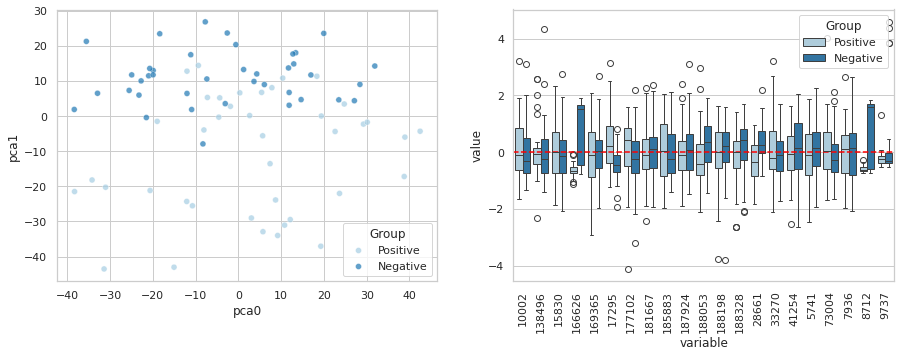

In [33]:
s2224.plot_qc()

In [5]:
s2224.processed_data

,10002,10022,10023,100246,10072,10121,10125,10136,1014,1018,...,9632,9655,9667,9737,9754,978,9913,9927,9928,Group
AS1,-0.241537,-1.397607,-1.154737,0.616293,-0.639924,0.587786,0.234422,0.386956,0.150274,-0.545727,...,0.827289,-0.842964,-0.408585,-0.272884,1.417971,-1.262842,0.127422,-0.296416,0.100532,Positive
AS2,1.916367,0.803369,0.154428,-0.053834,0.542147,1.828865,-0.100442,-0.889003,-0.480988,-0.320540,...,1.175799,-1.090885,-0.618632,-0.466802,0.258950,-0.603295,-0.487762,0.129213,-0.630289,Positive
AS3,0.953391,0.590781,-0.841518,0.514429,-0.609229,-0.168528,-0.106778,-0.351869,0.786183,-0.863982,...,-1.181888,-0.920308,0.686246,1.323818,-0.579722,0.934269,-0.221634,2.337876,0.868205,Positive
AS4,0.233067,-0.487125,-0.874943,1.261991,0.756482,0.163594,-0.147847,0.021866,-0.038770,-0.224223,...,0.712719,-1.115286,0.102415,-0.458342,-0.102602,-0.804457,-0.349042,0.090638,1.744632,Positive
AS5,0.077681,1.198039,0.972382,0.025874,-0.727315,-1.397864,-0.384120,0.652379,0.444920,-1.755211,...,-0.431859,-1.113886,1.018601,-0.192808,0.048524,-1.335356,-0.258952,-0.262421,-0.770192,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FU36,-0.293100,1.185993,0.724454,-1.152646,1.236476,0.948855,-0.023100,-0.482520,0.110574,-0.938313,...,-0.884293,2.039537,-0.839172,-0.420409,-0.815376,-0.956564,-0.211387,-0.227712,-0.383300,Negative
FU37,-0.427958,-0.490524,0.037437,-1.335802,0.672629,1.239886,-0.235690,-1.099804,-1.200657,3.029752,...,-1.710479,0.888806,-0.552370,-0.318693,0.171012,0.643889,-0.241472,-0.416670,-1.722394,Negative
FU38,0.086976,-0.490000,-0.087385,0.164458,-0.198052,-1.109367,-0.067803,-1.161631,-1.510473,0.805301,...,-0.198959,0.657782,-1.827207,-0.278362,-0.438343,1.255842,-0.016199,-0.288207,1.333904,Negative
FU39,0.221886,-1.184727,-0.171217,0.044034,0.353594,-0.094122,-0.189762,-1.335001,0.135617,1.334490,...,-0.382084,0.755203,0.632758,0.249931,-0.313148,-0.233605,-0.235338,-0.216631,2.468232,Negative


In [34]:
s6844 = MTBLSDataset(
    file_path = 'Studies/MTBLS6844', 
    id = 'MTBLS6844', 
    node_name = 'MTBLS6844', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'Severe','Control': 'Mild'},
    outliers='SEVERE6')

Missingness: 0.00%


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:73: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 0


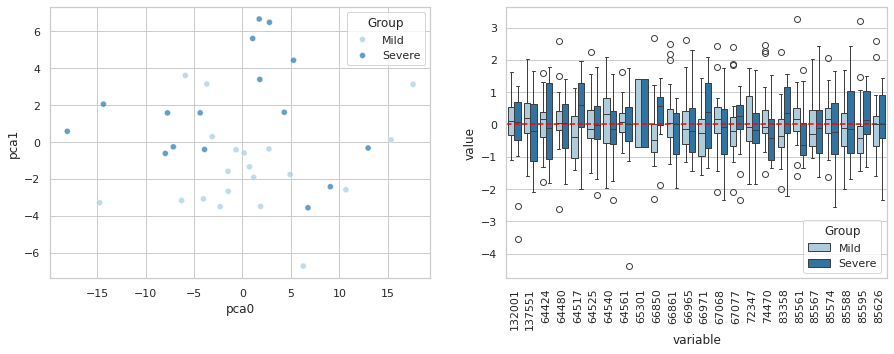

In [35]:
s6844.plot_qc()

In [8]:
# ONLY 3 CHEBIS HERE

# s718 = MTBLSDataset(
#     file_path = 'Studies/MTBLS718', 
#     id = 'MTBLS718', 
#     node_name = 'MTBLS718', 
#     md_group = 'Factor Value[Condition]', 
#     md_filter = {'Case': 'COVID-19', 'Control': 'Healthy Control'})

In [36]:
s1866 = MTBLSDataset(
    file_path = 'Studies/MTBLS1866', 
    id = 'MTBLS1866', 
    node_name = 'MTBLS1866', 
    md_group = 'Factor Value[Medical case]', 
    md_filter = {'Control': 'HEALTHY', 'Case': 'COVID-19'},
    outliers='SA 8')

3 assay files found
Missingness: 0.00%
Missingness: 0.00%
Missingness: 0.00%


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 249


/rds/general/user/cw2019/home/anaconda3/envs/py10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


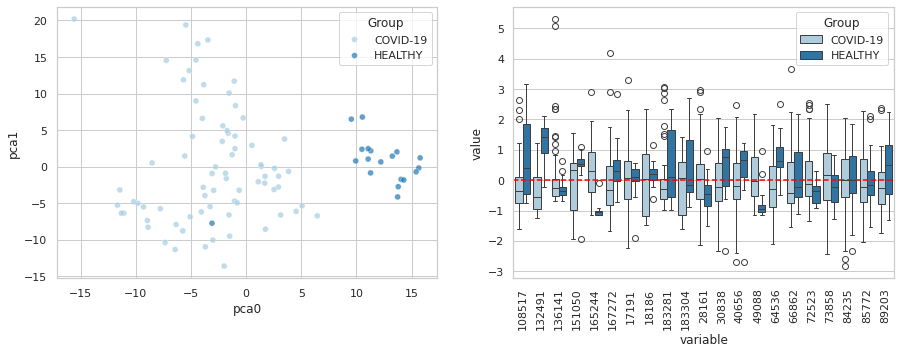

In [37]:
s1866.plot_qc()

In [38]:
s2336 = MTBLSDataset(
    file_path = 'Studies/MTBLS2336', 
    id = 'MTBLS2336', 
    node_name = 'MTBLS2336', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'COVID-19', 'Control':'Healthy (control)'})

Missingness: 0.00%


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:73: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 11


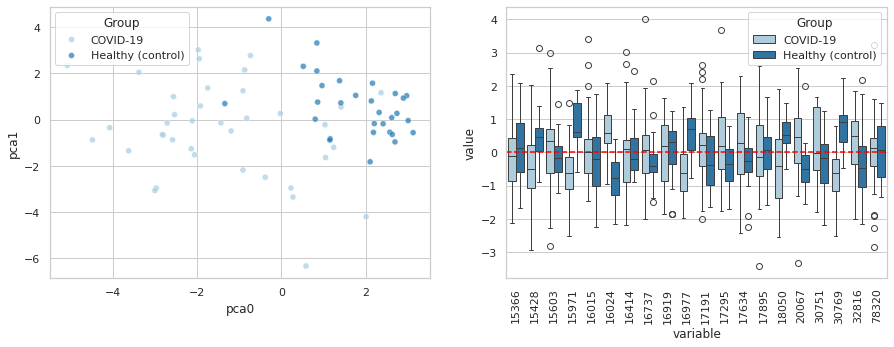

In [39]:
s2336.plot_qc()

In [40]:
s2542 = MTBLSDataset(
    file_path = 'Studies/MTBLS2542', 
    id = 'MTBLS2542', 
    remove_suffix=4,
    node_name = 'MTBLS2542', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Mild', 'Case':'Death'})

4 assay files found
Missingness: 0.00%
No CHEBIS for assay
Missingness: 0.00%
No CHEBIS for assay


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 409


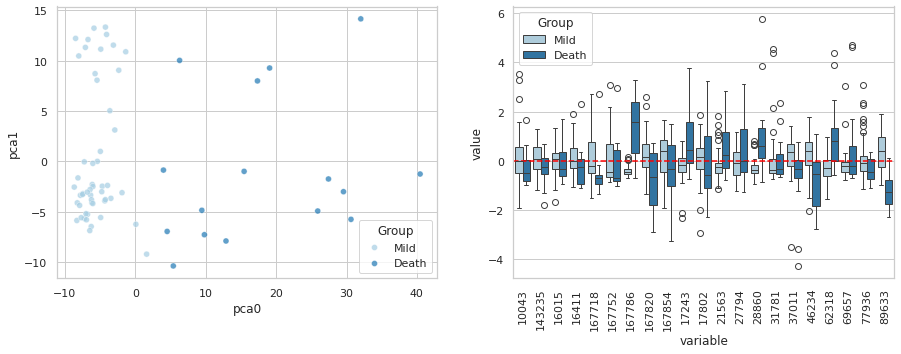

In [41]:
s2542.plot_qc()

In [73]:
s2291 = MTBLSDataset(
    file_path = 'Studies/MTBLS2291', 
    id = 'MTBLS2291', 
    node_name = 'MTBLS2291', 
    remove_prefix=9,
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Negative COVID-19', 'Case':'Severe COVID-19'},
    outliers=['CovidNeg_P251_P_3',
 'CovidNeg_P251_P_4',
 'CovidNeg_P252_P_3',
 'CovidNeg_P252_P_4',
 'CovidNeg_P253_P_3',
 'CovidNeg_P253_P_4',
 'CovidNeg_P254_P_3',
 'CovidNeg_P254_P_4',
 'CovidNeg_P257_P_3',
 'CovidNeg_P257_P_4',
 'CovidNeg_P258_P_3',
 'CovidNeg_P258_P_4',
 'CovidNeg_P259_P_3',
 'CovidNeg_P259_P_4',
 'CovidNeg_P260_P_3',
 'CovidNeg_P260_P_4',
 'CovidNeg_P261_P_3',
 'CovidNeg_P261_P_4',
 'CovidNeg_P262_P_3',
 'CovidNeg_P262_P_4',
 'CovidNeg_P263_P_3',
 'CovidNeg_P263_P_4',
 'CovidNeg_P264_P_3',
 'CovidNeg_P264_P_4',
 'CovidNeg_P265_P_3',
 'CovidNeg_P265_P_4',
 'CovidNeg_P266_P_3',
 'CovidNeg_P266_P_4',
 'CovidNeg_P267_P_3',
 'CovidNeg_P267_P_4',
 'CovidNeg_P268_P_3',
 'CovidNeg_P268_P_4',
 'CovidNeg_P269_P_3',
 'CovidNeg_P269_P_4',
 'CovidNeg_P270_P_3',
 'CovidNeg_P270_P_4',
 'CovidNeg_P271_P_3',
 'CovidNeg_P271_P_4',
 'CovidSevere_P273_P_3',
 'CovidSevere_P273_P_4',
 'CovidSevere_P272_P_3',
 'CovidSevere_P272_P_4',
 'CovidSevere_P283_P_3',
 'CovidSevere_P283_P_4',
 'CovidSevere_P284_P_3',
 'CovidSevere_P284_P_4',
 'CovidSevere_P285_P_3',
 'CovidSevere_P285_P_4']
)

1 assay file found
Missingness: 18.21%


/var/tmp/pbs.9850431.pbs/ipykernel_644150/610929438.py:77: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 50


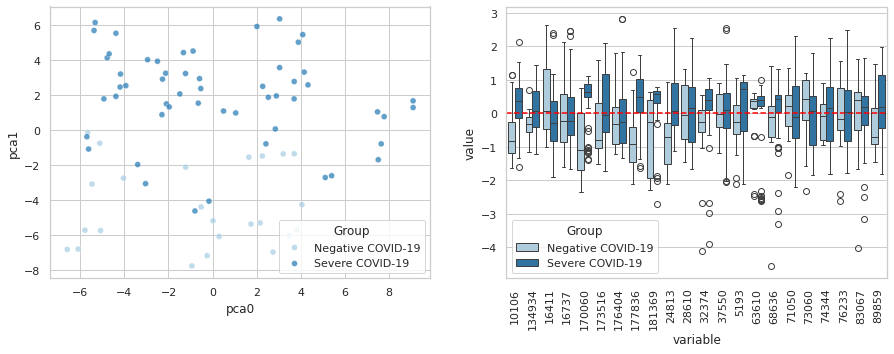

In [74]:
s2291.plot_qc()

In [44]:
s718 = MTBLSDataset(
    file_path = 'Studies/MTBLS718', 
    id = 'MTBLS718', 
    node_name = 'MTBLS718', 
    md_group = 'Factor Value[Condition]', 
    md_filter = {'Case':'COVID-19', 'Control':'Healthy Control'})

3 assay files found
No CHEBIS for assay
No CHEBIS for assay


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:46: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep='\t')
/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:59: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Missingness: 0.00%
Number of differentially abundant metabolites: 1


In [45]:
s2014 = MTBLSDataset(
    file_path = 'Studies/MTBLS2014', 
    id = 'MTBLS2014', 
    node_name = 'MTBLS2014', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Control':'Healthy', 'Case':'Patient (+) SARS-CoV-2'},
    outliers=['12JUN2020_AAA_COV_PL_068'])

Missingness: 0.00%


/var/tmp/pbs.9850431.pbs/ipykernel_644150/759745839.py:73: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  proc_data = proc_data.groupby(by=proc_data.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


Number of differentially abundant metabolites: 9


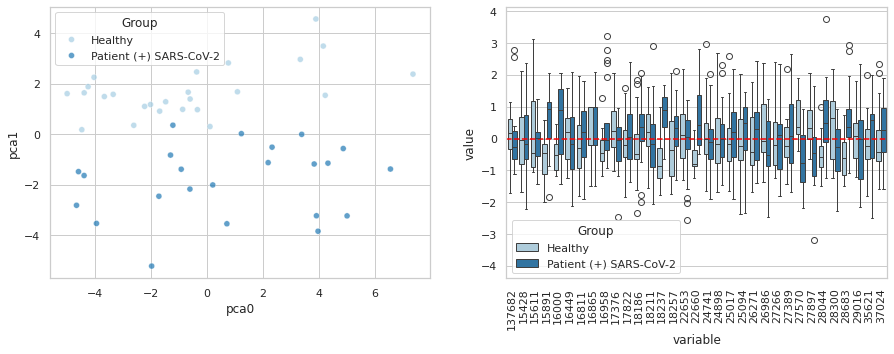

In [46]:
s2014.plot_qc()

## Differential metabolites per study

In [75]:
# most or all covid studies here
studies = [s2014, s1866, s2224, s2336, s2542, s2291, s718, s6844]

In [76]:
# studies for COVID19 case study which have enough DA metabo to build the graph
studies = [s2014, s1866, s2224, s2542, s2291, s2336]

In [77]:
DA_res = pd.DataFrame(
    zip([len(i.DA_metabolites) for i in studies], [len(i.processed_data.columns)-1 for i in studies]),
    index=[i.node_name for i in studies],
    columns=['DA_count', 'ChEBI and Identified metabolite count']
)

In [78]:
DA_res

,DA_count,ChEBI and Identified metabolite count
MTBLS2014,9,33
MTBLS1866,249,475
MTBLS2224,759,2586
MTBLS2542,409,696
MTBLS2291,50,130
MTBLS2336,11,20


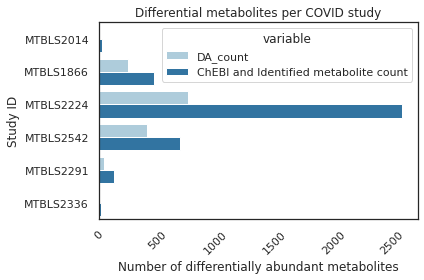

In [83]:
sns.set_style('white')
sns.barplot(
    data=DA_res.melt(ignore_index=False).reset_index(),
    y='index',
    x='value',
    hue='variable',
    orient='h'
)
plt.xlabel('Number of differentially abundant metabolites')
plt.ylabel('Study ID')
plt.title('Differential metabolites per COVID study')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [84]:
# count the number of identifier types per study
ids_counts = [pd.Series(i.all_ids.nunique(), name=i.id) for i in studies]

In [85]:
ids_counts = pd.concat(ids_counts, axis=1).T

In [86]:
ids_counts = ids_counts[['database_identifier',
 'chemical_formula',
 'smiles',
 'inchi',
 'metabolite_identification',
 'mass_to_charge',
 'retention_time',
 'reliability']]

In [87]:
ids_counts

,database_identifier,chemical_formula,smiles,inchi,metabolite_identification,mass_to_charge,retention_time,reliability
MTBLS2014,33.0,28.0,29.0,29.0,34.0,27.0,34.0,0.0
MTBLS1866,211.0,196.0,90.0,62.0,476.0,464.0,464.0,0.0
MTBLS2224,1094.0,929.0,1089.0,838.0,1153.0,857.0,568.0,0.0
MTBLS2542,0.0,0.0,0.0,0.0,177.0,1.0,154.0,0.0
MTBLS2291,934.0,1158.0,917.0,915.0,1325.0,1.0,1702.0,0.0
MTBLS2336,20.0,18.0,18.0,18.0,22.0,NaN,NaN,0.0


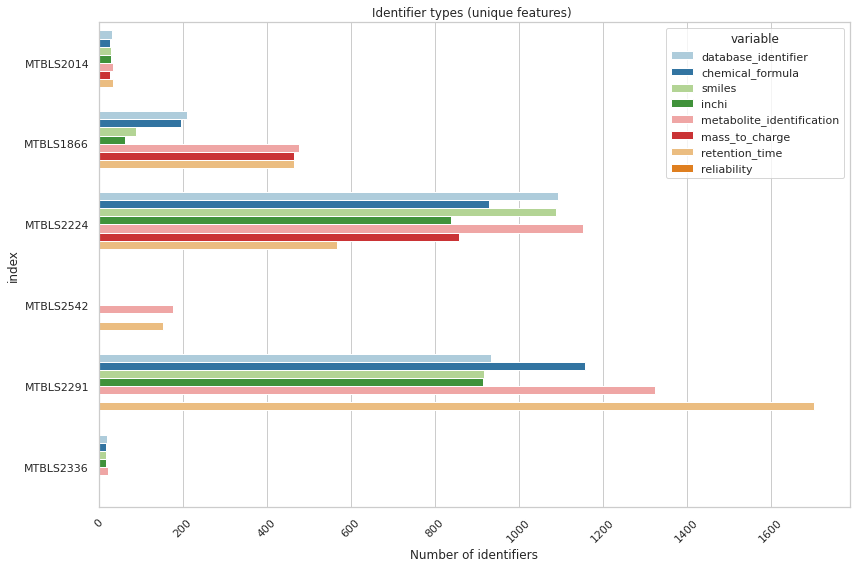

In [93]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=ids_counts.melt(ignore_index=False).reset_index(),
    y='index',
    x='value',
    hue='variable',
    orient='h'
)
plt.xticks(rotation=45)
plt.xlabel('Number of identifiers')
plt.title('Identifier types (unique features) ')
plt.tight_layout()
plt.show()

## Bipartite graph

In [94]:
def get_bipartite(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.DA_metabolites for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes

In [95]:
covid_bpt, covid_bottom_nodes, covid_top_nodes = get_bipartite(studies)

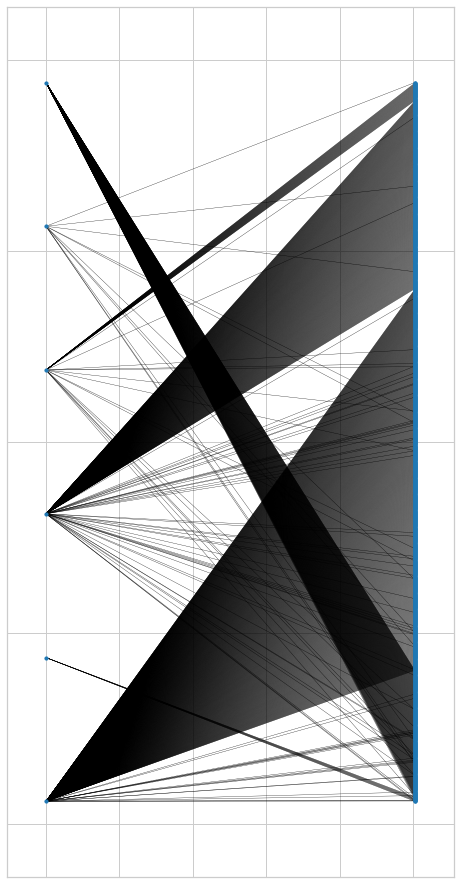

In [96]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    covid_bpt,
    pos = nx.drawing.layout.bipartite_layout(covid_bpt, covid_bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()


MTBLS2014
MTBLS1866
MTBLS2224
MTBLS2542
MTBLS2291
MTBLS2336


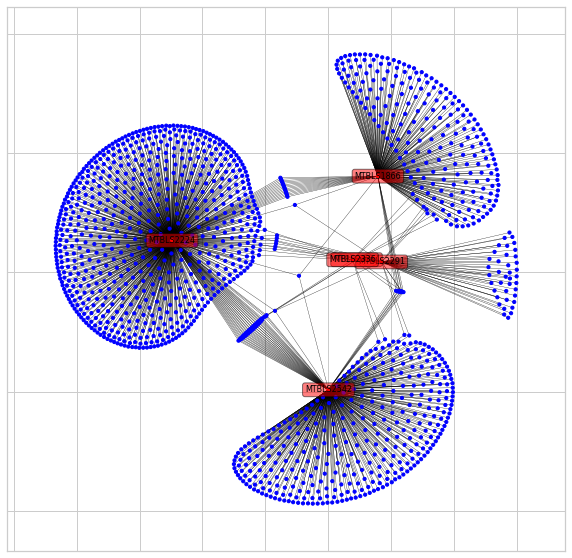

In [97]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(covid_bpt)
color_map = []
labels = {}
for node in covid_bpt:
    if node in covid_bottom_nodes:
        color_map.append('red')
        labels[node] = node
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    covid_bpt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) 

nx.draw_networkx_labels(covid_bpt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [98]:
biadj_mat = nx.bipartite.biadjacency_matrix(covid_bpt, row_order=covid_bottom_nodes, column_order=covid_top_nodes).toarray()
biadj_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))

In [99]:
biadj_mat.shape

(6, 1395)

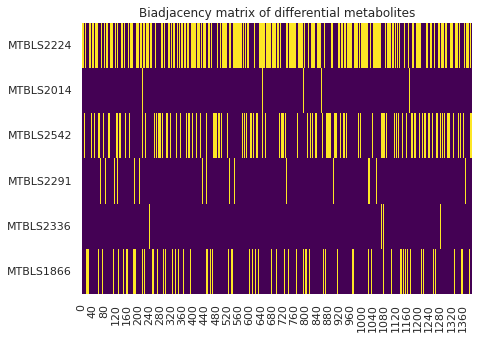

In [100]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(biadj_mat, cmap='viridis', cbar=False)
ax.set_yticklabels(covid_bottom_nodes, rotation=0)
ax.set_title('Biadjacency matrix of differential metabolites')
plt.show()


## Upset plot of metabolites

In [101]:
# filter most commonly co-occurring metabolites
freq_met = biadj_df.loc[:, (biadj_df.sum() > 1)]

# differential metabolite cooccurences
all_da_sets = [set(i.DA_metabolites) for i in studies]

# most commonly cooccuring metabolites sets
co_occuring_sets = freq_met.apply(lambda row: set(freq_met.columns[row == 1]), axis=1).tolist()


In [102]:
freq_met

,17126,133456,16914,70979,320055,30851,17231,50202,15756,24813,...,2198,15318,18183,15971,28834,74791,16283,17306,18344,17697
MTBLS2224,0,1,1,0,1,1,1,1,1,1,...,1,1,0,0,1,0,1,1,1,1
MTBLS2014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS2542,1,0,1,1,0,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
MTBLS2291,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
MTBLS2336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MTBLS1866,0,1,0,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


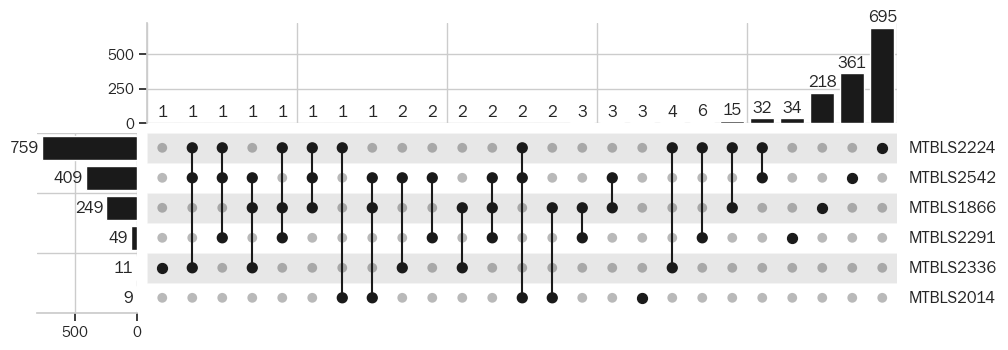

In [345]:
upset_data = UpsetData.from_sets(all_da_sets, sets_names=[i.node_name for i in studies])
us = ma.upset.Upset(
    data=upset_data, 
    orient="h",
    add_labels=True,
    )


us.add_legends(box_padding=0)
us.set_margin(0.3)
us.render()

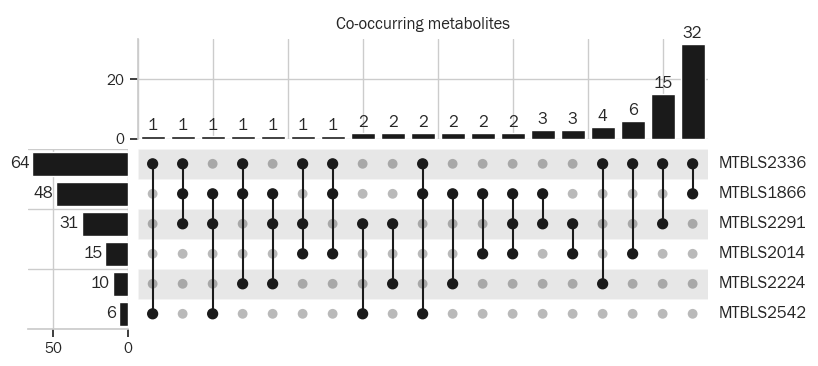

In [346]:
upset_data = UpsetData.from_sets(
    co_occuring_sets, 
    sets_names=[i.node_name for i in studies])

us = ma.upset.Upset(
    data=upset_data, 
    orient="h",
    add_labels=True,
    )


us.add_legends(box_padding=0)
us.set_margin(0.3)

# us.add_right(ma.plotter.Bar(
#     data=study_sizes_df,
#     y='Study_ID',
#     x='Total_metabolites',
#     orient='h'
#     # x='Study_ID',
#     # y='index'
# ))

us.add_title(top="Co-occurring metabolites")

us.render()

Then do a plot of the most frequently co-occuring metabolites and add the direction of FC.

In [220]:
# filter most commonly co-occurring metabolites
freq_met = biadj_df.loc[:, (biadj_df.sum() > 2)].columns.tolist()

# df of da results for each metabolite in each study
stat_per_study = []
for i in studies:
    df = i.pval_df
    df = df[df.index.isin(freq_met)]
    df['Study'] = i.node_name
    df['ChEBI'] = df.index
    df['Metabolite_name'] = df.index.map(chebi_names)
    
    stat_per_study.append(df)

stat_per_study_df = pd.concat(stat_per_study)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_18800\2031878595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Study'] = i.node_name
C:\Users\cw2019\AppData\Local\Temp\ipykernel_18800\2031878595.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ChEBI'] = df.index
C:\Users\cw2019\AppData\Local\Temp\ipykernel_18800\2031878595.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

C:\Users\cw2019\AppData\Local\Temp\ipykernel_18800\1329616824.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


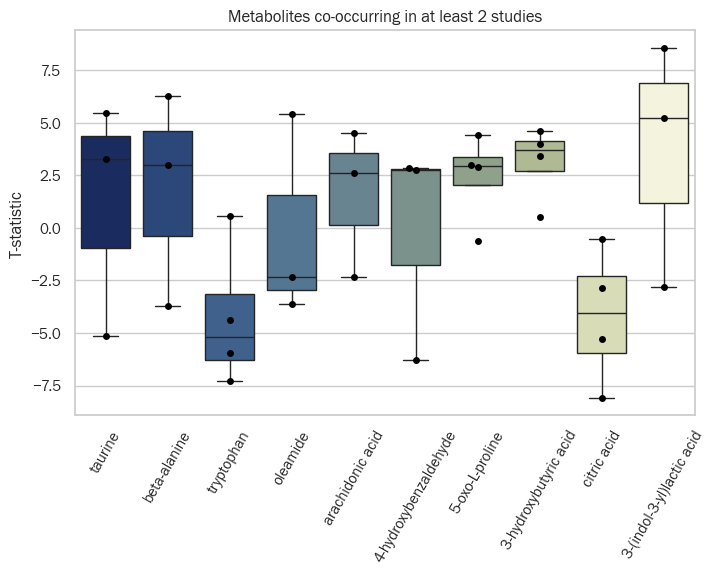

In [347]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.set_theme(
    style='whitegrid',
    palette='cmc.davos',
    font='Tahoma',
)

sns.boxplot(
    data=stat_per_study_df,
    x='Metabolite_name',
    y='Stat',
    palette='cmc.davos',
    ax=ax,
    showfliers=False,
    # hue='Study'
)

sns.swarmplot(
    data=stat_per_study_df,
    x='Metabolite_name',
    y='Stat',
    color='black',
    ax=ax,
    # hue='Study'
)

plt.title('Metabolites co-occurring in at least 2 studies')
plt.ylabel('T-statistic ')
plt.xlabel('')
plt.xticks(rotation=60)
plt.show()

For a metabolite of interest, look at the abundance level in the processed data

In [321]:
metab_of_interest = '18183'
abundance_vals = []
for i in studies:
    try:
        abundance = pd.DataFrame(i.processed_data.loc[:, [metab_of_interest, 'Group']])
        md_name_dict = dict(zip(i.md_filter.values(), i.md_filter.keys()))
        abundance['Group'] = abundance['Group'].map(md_name_dict)
        abundance['StudyID'] = i.node_name
        abundance_vals.append(abundance)
    except KeyError:
        pass

abundance_df = pd.concat(abundance_vals)

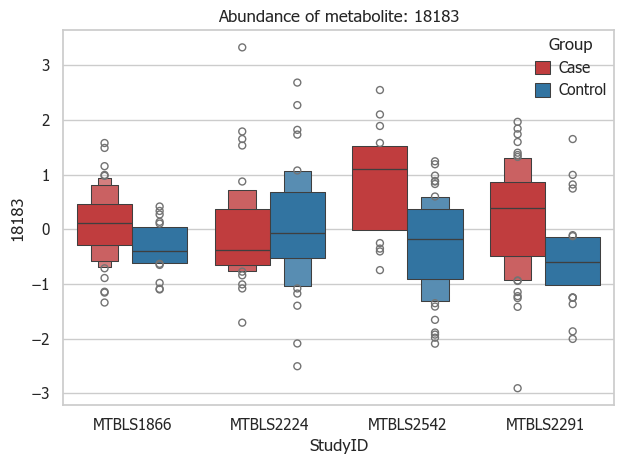

In [352]:
sns.boxenplot(
    data=abundance_df,
    x='StudyID',
    y=metab_of_interest,
    hue='Group',
    palette={'Case':'tab:red', 'Control':'tab:blue'},
    # cmap
)

plt.title('Abundance of metabolite: '+ metab_of_interest)
plt.tight_layout()
plt.show()

In [360]:
stat_per_study_df.head()

,P-value,Stat,Direction,FDR_P-value,Study,ChEBI,Metabolite_name
15891,0.000002,5.446876,Up,0.000020,MTBLS2014,15891,taurine
16958,0.004648,2.975641,Up,0.016009,MTBLS2014,16958,beta-alanine
27897,0.000067,-4.383241,Down,0.000298,MTBLS2014,27897,tryptophan
116314,0.022190,-2.326908,Down,0.043375,MTBLS1866,116314,oleamide
15843,0.000018,4.523364,Up,0.000110,MTBLS1866,15843,arachidonic acid


Add significance testing using `statannotations` package

In [362]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

stat_per_study_df_filt = stat_per_study_df[stat_per_study_df['ChEBI'] == metab_of_interest]
pvalue_asterisks = [convert_pvalue_to_asterisks(p) for p in stat_per_study_df_filt['FDR_P-value']]

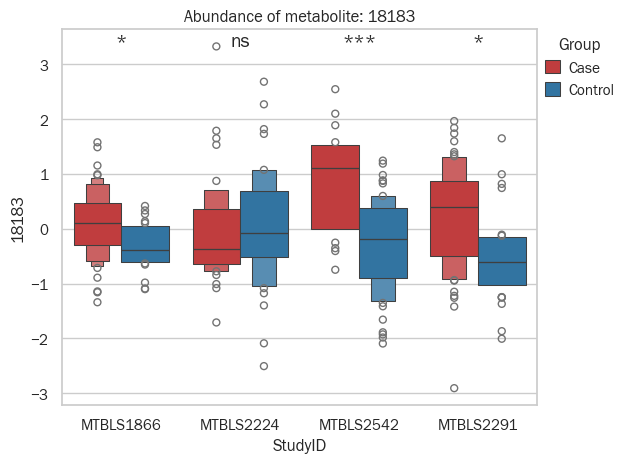

In [383]:
fig, ax = plt.subplots()
fig.subplots_adjust(top=0.44)
sns.boxenplot(
data=abundance_df,
x='StudyID',
y=metab_of_interest,
hue='Group',
palette={'Case':'tab:red', 'Control':'tab:blue'},
# cmap
)

y_position = abundance_df[metab_of_interest].max() * 1
for idx, pval in enumerate(pvalue_asterisks):
    plt.text(x=idx, y=y_position, s=pval, ha='center', fontsize=14, fontweight='bold')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Abundance of metabolite: '+ metab_of_interest)
plt.tight_layout()
plt.show()

## Adjacency matrix

c:\Users\cw2019\AppData\Local\anaconda3\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


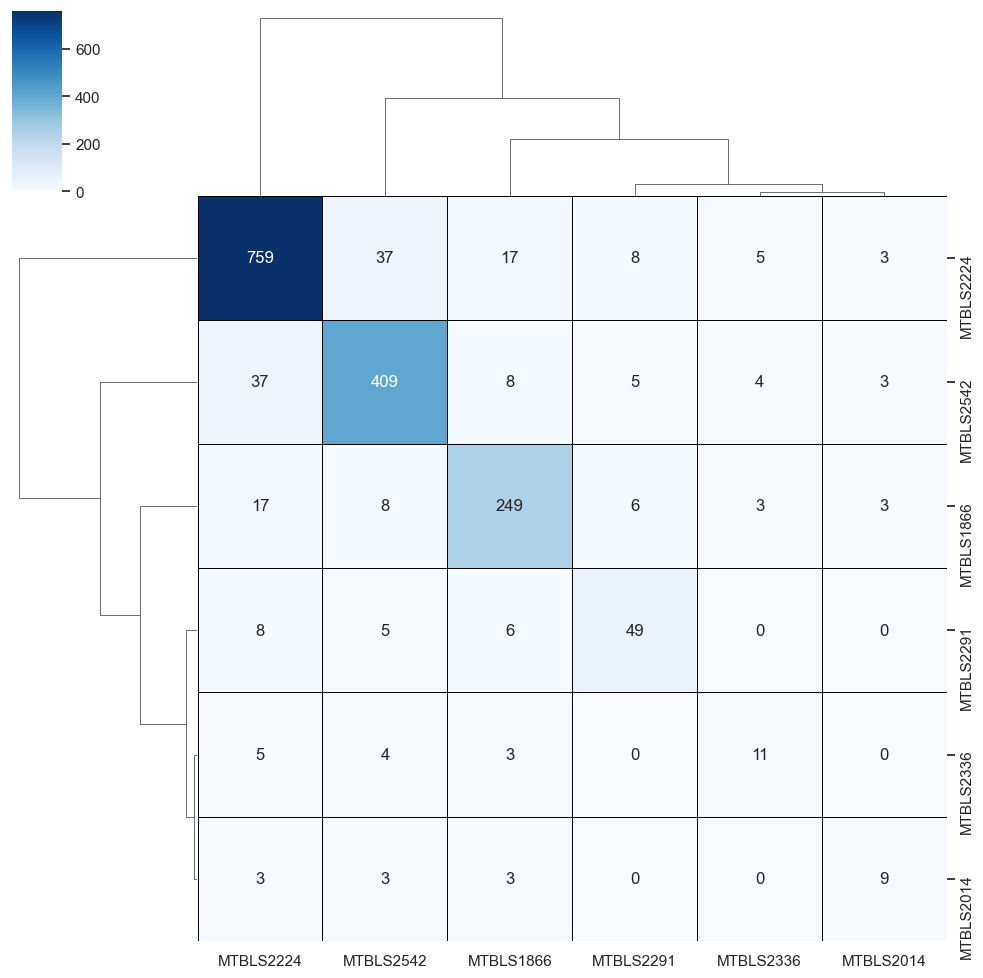

In [197]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(covid_bottom_nodes), columns=list(covid_bottom_nodes))

# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
# ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [198]:
# look at overlap of metabolites between studies

overlap = pd.DataFrame(
    np.zeros((len(studies), len(studies))), 
    index=[i.node_name for i in studies], 
    columns=[i.node_name for i in studies]
)

for i in range(len(studies)):
    for j in range(len(studies)):
        overlap.iloc[i, j] = len(set(studies[i].processed_data.iloc[:, :-1].columns) & set(studies[j].processed_data.iloc[:, :-1].columns))


c:\Users\cw2019\AppData\Local\anaconda3\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


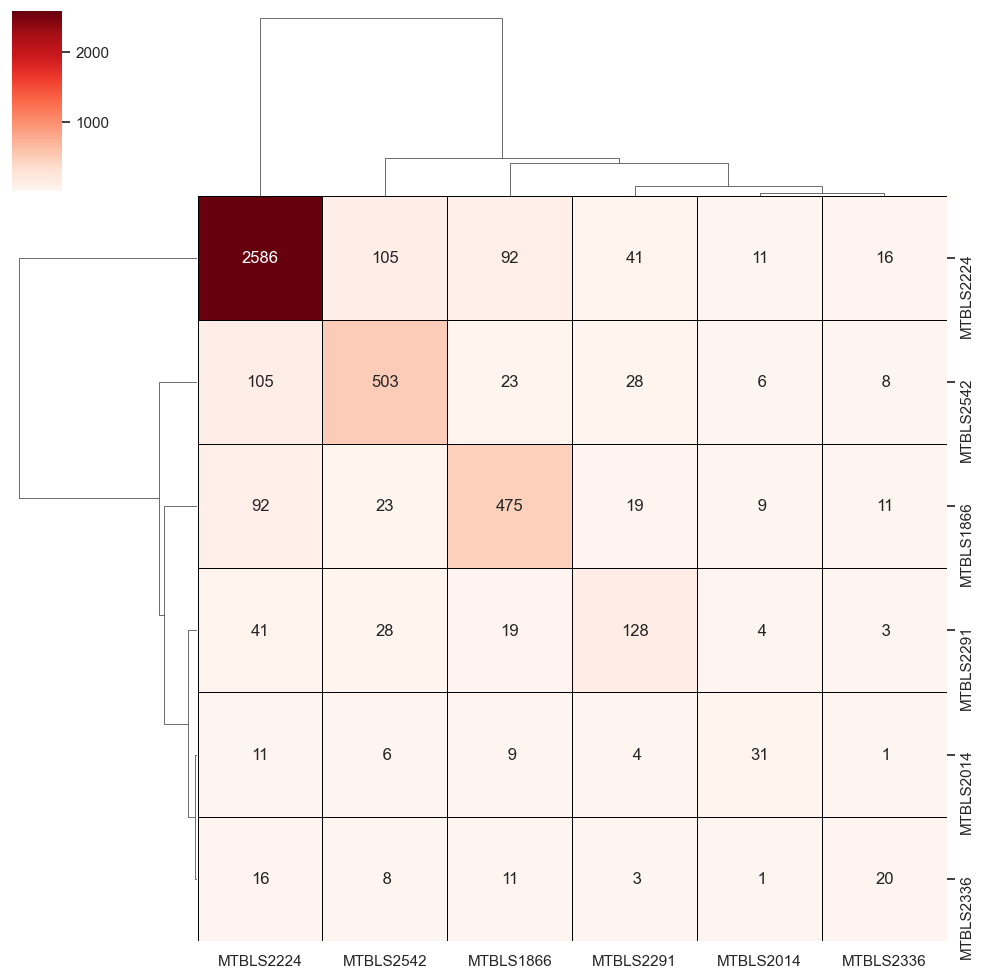

In [ ]:

sns.set(style='white')
sns.clustermap(overlap, cmap='Reds', annot=True, square=True, fmt='2g', linewidths=0.5, linecolor='black')
plt.show()

## Disease-metabolite network

In [199]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(covid_top_nodes), columns=list(covid_top_nodes))


In [ ]:
adj_mat_dmn

,87440,188109,167811,168703,50158,18332,28718,17295,167814,174791,...,89649,16235,35940,16802,167815,30751,169181,73018,165734,36610
87440,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
188109,0,1,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
167811,0,0,1,0,0,1,1,0,1,0,...,1,1,0,0,1,0,0,1,0,0
168703,0,1,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
50158,0,1,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30751,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
169181,0,1,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
73018,0,0,1,0,0,1,1,0,1,0,...,1,1,0,0,1,0,0,1,0,0
165734,0,1,0,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0


In [200]:

# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [201]:
edgelist_dmn.sort_values('weight', ascending=False)

,source,target,weight
120439,15843,18183,3
119970,15843,15843,3
1915335,20067,20067,3
1369890,30769,30769,3
718601,15891,16958,3
...,...,...,...
708766,16467,17361,2
708667,16467,15891,2
708660,16467,16467,2
708611,16467,16535,2


In [202]:
biadj_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))

In [ ]:
biadj_df

,72665,188227,16467,28832,165468,18344,180369,28591,134428,73224,...,62064,10106,188196,15318,75449,188062,28927,15822,88461,94764
MTBLS2542,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
MTBLS2014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS2224,1,1,1,1,1,1,1,1,0,1,...,1,0,1,1,0,1,0,1,1,0
MTBLS2336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS1866,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
MTBLS2291,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
biadj_df['18183']

MTBLS2336    0
MTBLS2224    0
MTBLS1866    1
MTBLS2291    1
MTBLS2014    0
MTBLS2542    1
Name: 18183, dtype: int32

In [ ]:
biadj_df.loc[:, biadj_df.sum(axis=0) == 3]

,18183,27897,15843,116314,18050,24813,17597
MTBLS2542,1,1,1,0,1,1,1
MTBLS2014,0,1,0,0,0,0,0
MTBLS2224,0,0,0,1,1,1,1
MTBLS2336,0,0,0,0,1,0,0
MTBLS1866,1,1,1,1,0,0,1
MTBLS2291,1,0,1,1,0,1,0


In [ ]:
s2542.processed_data[['18183', 'Group']]

,18183,Group
20P02820133_BEHC18,0.292173,Mild
20P02820132_BEHC18,-1.888162,Mild
20P02820131_BEHC18,-1.352191,Mild
20P02820135_BEHC18,0.369825,Mild
20P02820134_BEHC18,-1.138799,Mild
...,...,...
20P02820143_BEHC18,0.342752,Mild
20P02820140_BEHC18,-1.413611,Mild
20P02820141_BEHC18,-0.264954,Mild
20P02820075_BEHC18,0.386905,Death


<Axes: xlabel='18183'>

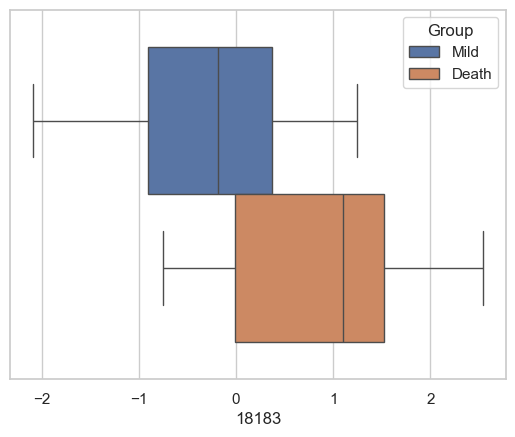

In [ ]:
# validate direction 
sns.boxplot(data=s2542.processed_data[['18183', 'Group']],
            x='18183',
            hue='Group',)

In [ ]:
s1866.processed_data[['18183', 'Group']]

,18183,Group
4,-0.891862,COVID-19
9,0.474862,COVID-19
12,0.512197,COVID-19
14,0.253983,COVID-19
20,0.436424,COVID-19
...,...,...
SA 9,-0.389246,HEALTHY
SA 10,-0.008548,HEALTHY
SA 11,0.334791,HEALTHY
SA 12,0.136005,HEALTHY


<Axes: xlabel='18183'>

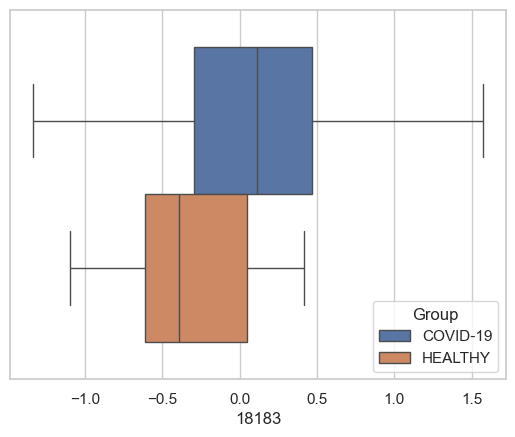

In [ ]:
sns.boxplot(data=s1866.processed_data[['18183', 'Group']],
            x='18183',
            hue='Group',)

<Axes: xlabel='18183'>

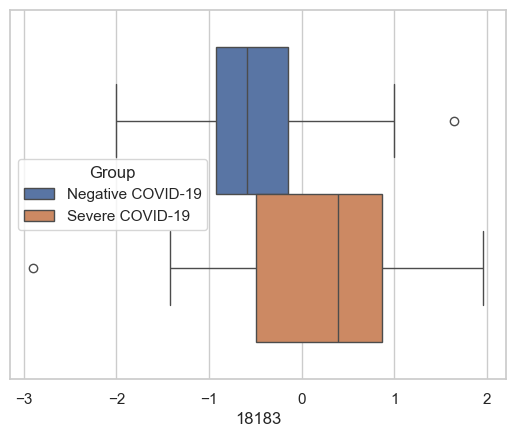

In [ ]:
# validate direction 
sns.boxplot(data=s2291.processed_data[['18183', 'Group']].drop_duplicates(),
            x='18183',
            hue='Group',)

In [203]:
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')


In [204]:
print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())


82
907


In [ ]:
max(list(nx.get_node_attributes(dmn_graph, 'degree').values()))

51

In [ ]:
nx.density(dmn_graph)


0.2321012321012321

In [ ]:
nx.average_clustering(dmn_graph)


0.9424426545418296

In [ ]:
len(nx.community.louvain_communities(dmn_graph))

5

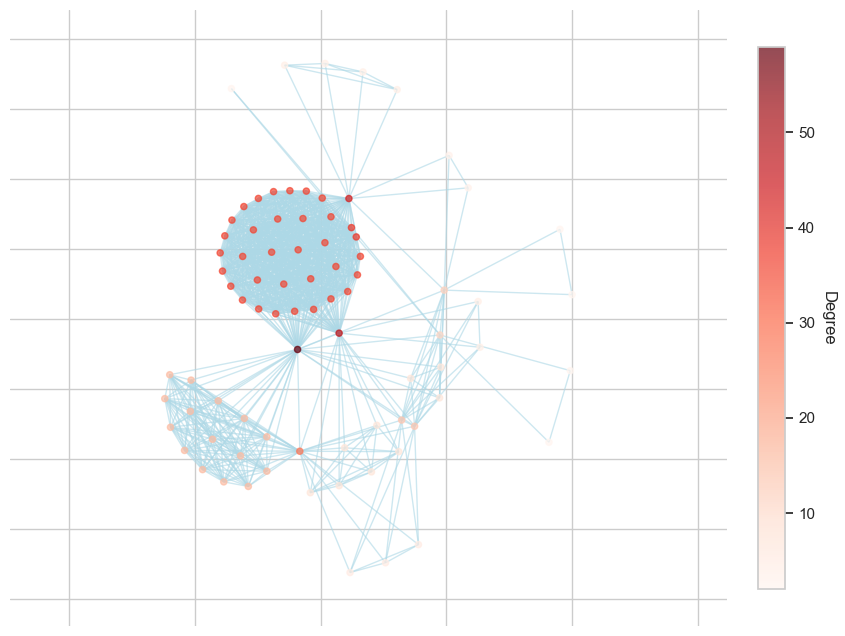

In [ ]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=20,
                       node_color=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       cmap='Reds',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                       edge_color='lightblue',
                       alpha=0.6)

# Add a colorbar
cbar = plt.colorbar(nds, fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")

plt.box(False)
plt.margins(x=0.3)
plt.show()


In [ ]:
(biadj_mat_df.sum(axis=0) > 2).sum()

7

In [206]:
biadj_mat_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))
study_contributions = biadj_mat_df.divide(biadj_mat_df.sum(axis=0), axis=1)
# add contribution from each study 
nx.set_node_attributes(dmn_graph, study_contributions.to_dict())

# normalise by the number of studies


In [208]:
# add direction of metabolite changes

# get direction foe each study
dirs = [pd.Series(i.pval_df['Direction'], name=i.id) for i in studies]
dirs = [d[~d.index.duplicated(keep='first')] for d in dirs]

In [209]:
dirs = [d.replace({'Up': 1, 'Down': -1}) for d in dirs]

C:\Users\cw2019\AppData\Local\Temp\ipykernel_18800\2459888317.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dirs = [d.replace({'Up': 1, 'Down': -1}) for d in dirs]


In [210]:
dirs_all = pd.concat(dirs, axis=1)

In [ ]:
dirs_all.head()

,MTBLS2014,MTBLS1866,MTBLS2224,MTBLS2542,MTBLS2291,MTBLS2336
15428,1.0,-1.0,1.0,NaN,NaN,-1.0
15611,-1.0,NaN,NaN,NaN,NaN,NaN
15891,1.0,NaN,1.0,-1.0,NaN,NaN
16000,1.0,1.0,1.0,NaN,NaN,NaN
16449,-1.0,NaN,NaN,-1.0,NaN,NaN


In [211]:
for i in studies:
    nx.set_node_attributes(dmn_graph, dirs_all[i.id], i.id+'_direction')

In [ ]:
# export network
nx.write_graphml(dmn_graph, 'covid_metabolites_mz.graphml')

Colour the nodes by 
- m/z ratio 

Label the nodes by 
- metabolite name

### Full network

In [ ]:
# similarity of metabolites between studies
def get_bipartite_full(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.processed_data.iloc[:, :-1].columns.tolist() for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.full_connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes


In [ ]:
# s2014, s1866, s2224, s2336, s2542, s2291
covid_bpt_full, covid_bottom_nodes_full, covid_top_nodes_full = get_bipartite_full([s2014, s1866, s2224, s2336, s2542, s2291])


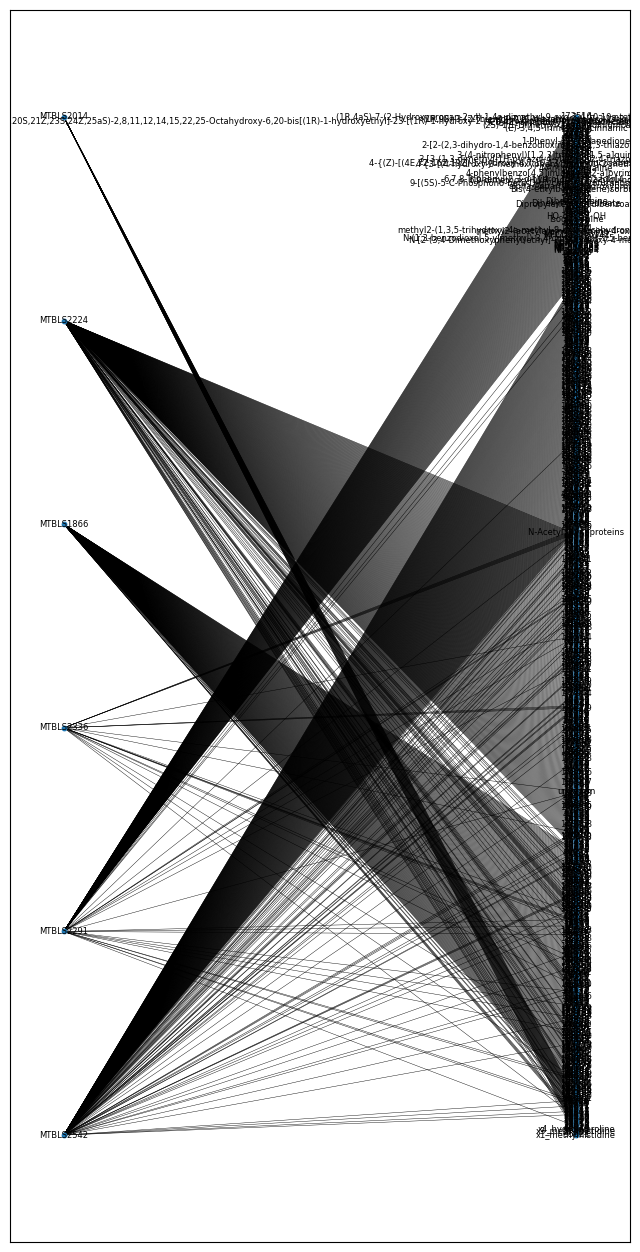

In [ ]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    covid_bpt_full,
    pos = nx.drawing.layout.bipartite_layout(covid_bpt_full, covid_bottom_nodes_full),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()

MTBLS2014
MTBLS1866
MTBLS2224
MTBLS2336
MTBLS2542
MTBLS2291


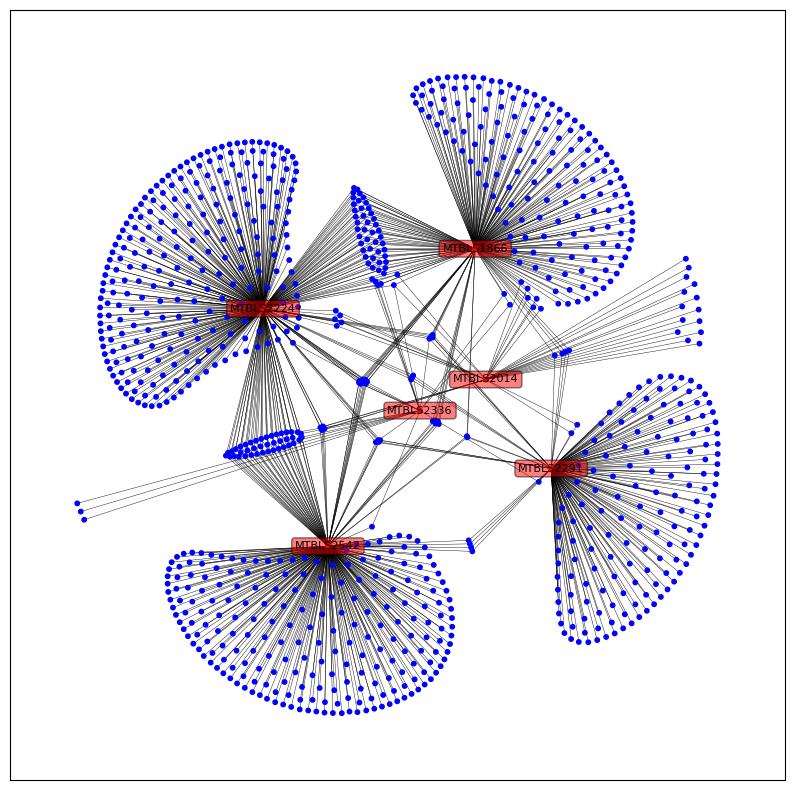

In [ ]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(covid_bpt_full)
color_map = []
labels = {}
for node in covid_bpt_full:
    if node in covid_bottom_nodes_full:
        print(node)
        color_map.append('red')
        labels[node] = node
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    covid_bpt_full,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
nx.draw_networkx_labels(covid_bpt_full, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [ ]:
biadj_mat_full = nx.bipartite.biadjacency_matrix(covid_bpt_full, 
                                                 row_order=covid_bottom_nodes_full, 
                                                 column_order=covid_top_nodes_full).toarray()


In [ ]:
biadj_mat_full_df = pd.DataFrame(biadj_mat_full, index=list(covid_bottom_nodes_full), columns=list(covid_top_nodes_full))

In [ ]:

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_full = pd.DataFrame(biadj_mat_full @ biadj_mat_full.T, index=list(covid_bottom_nodes_full), columns=list(covid_bottom_nodes_full))


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


NameError: name 'ax' is not defined

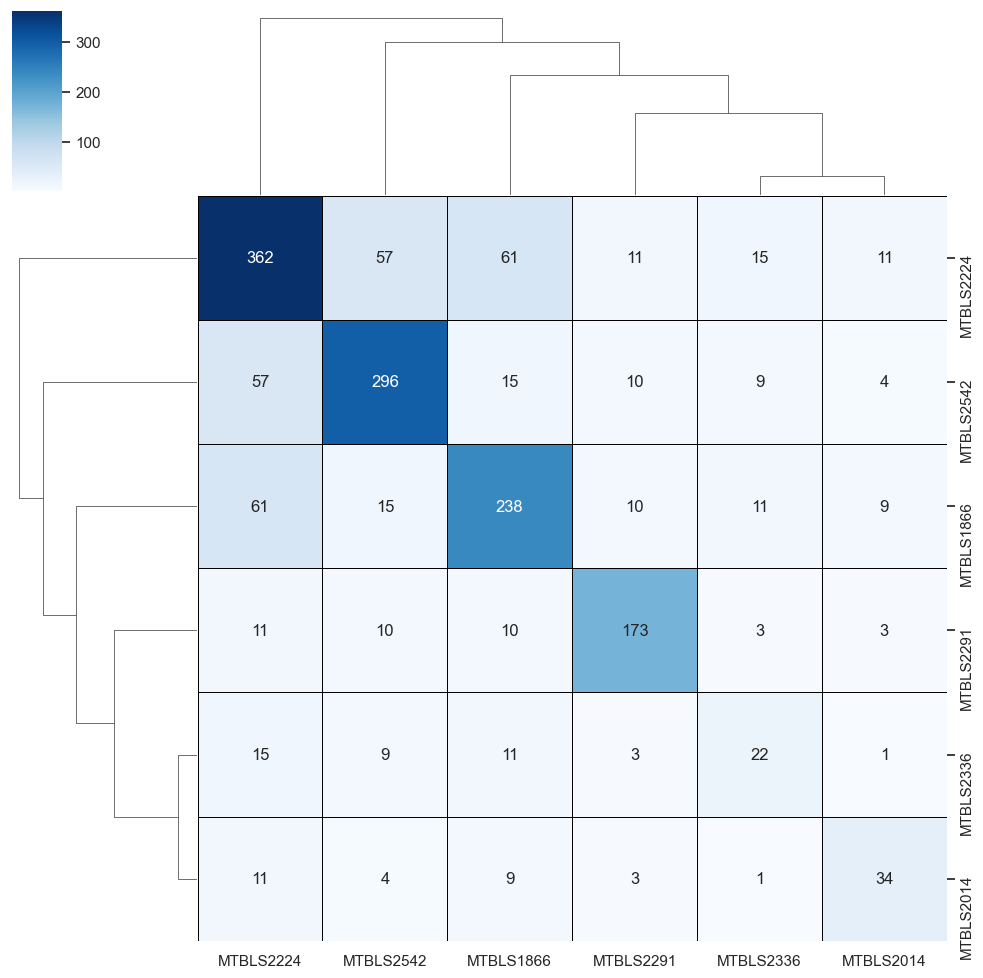

In [ ]:

# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat_full, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [ ]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn_full = pd.DataFrame(biadj_mat_full.T @ biadj_mat_full, index=list(covid_top_nodes_full), columns=list(covid_top_nodes_full))

In [ ]:
# make pandas edgelist
edgelist_dmn = adj_mat_dmn_full.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [ ]:
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')


In [ ]:
# set da metabolites as node attributes
for i in studies:
    nx.set_node_attributes(dmn_graph, dict.fromkeys(i.DA_metabolites, 'DA'), 'DA')

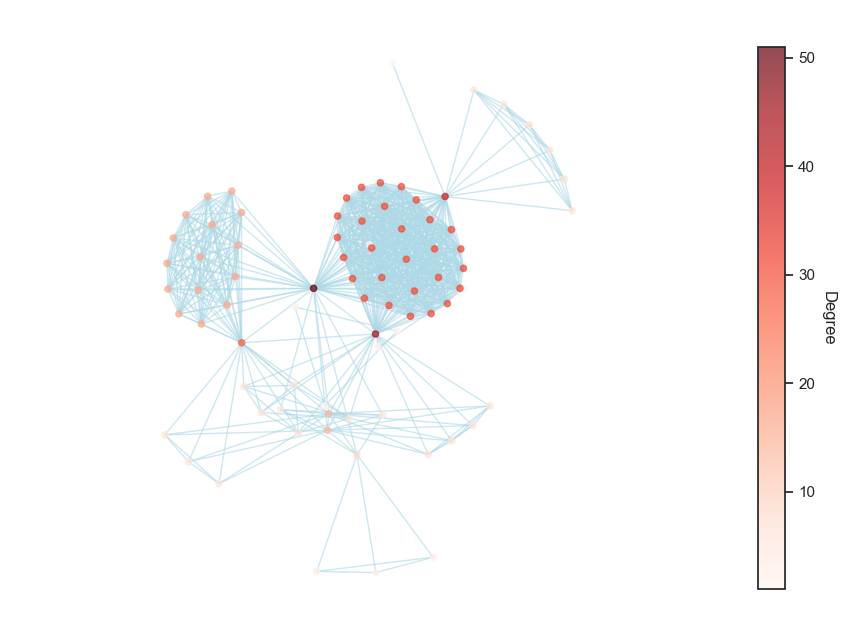

In [ ]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=20,
                       node_color=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       cmap='Reds',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                       edge_color='lightblue',
                       alpha=0.6)

# Add a colorbar
cbar = plt.colorbar(nds, fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")

plt.box(False)
plt.margins(x=0.3)
plt.show()


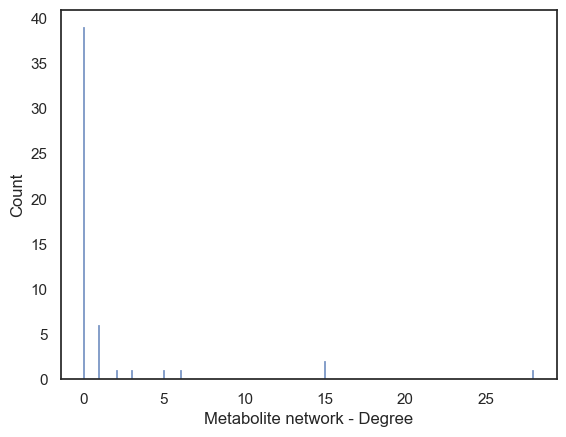

In [ ]:
sns.histplot(nx.degree_histogram(dmn_graph))
plt.xlabel('Metabolite network - Degree')
plt.show()

In [ ]:
dmn_graph.nodes

NodeView(('16857', '16734', '16002', '27226', '16411', '17596', '15318', '16927', '15584', '30805', '16995', '16443', '15887', '28197', '15428', '75342', '15891', '18050', '28747', '16359', '17754', '70979', '6650', '25017', '10072', '16737', '16070', '42504', '43355', '15971', '28875', '9754', '422', '27823', '17151', '16112', '17895', '32816', '18257', '28837', '30746', '16828', '15824', '60645', '15882', '62064', '15440', '15741', '17351', '75455', '30813', '37084', '30794', '17295', '17521', '9008', '16977', '18012', '17097', '30838', '16000', '16755', '16704', '24813', '48131', '15573', '86371', '18344', '36005', '22605', '69081', '36635', '22470', '17368', '15756', '16914', '28579', '16125', '16414', '16027', '16015', '17231', '1148', '33511', '87440', '17475', '15843', '22652', '28842', '17113', '17053', '183300', '16283', '16199', '183299', '30915', '27732', '16113', '16024', '16196', '116314', '7916', '30769', '17802', '29019', '17203', '33118', '16958', '28834', '24266', '159

In [ ]:
dmn_graph.nodes['16411']

{'degree': 69, 'name': 'indole-3-acetic acid', 'mass': 175.184}

In [ ]:
# add extra weight for DA-DA connections
for i in dmn_graph.nodes:
    if 'DA' in dmn_graph.nodes[i].keys():
        for j in dmn_graph.nodes:
            if 'DA' in dmn_graph.nodes[j].keys():
                if dmn_graph.has_edge(i, j):
                    dmn_graph[i][j]['DA_weight'] = 1


In [ ]:
biadj_mat_full_df

,91038,84223,167735,28197,28727,75456,87440,73060,84849,27810,...,167808,139058,70976,37721,167796,40992,183272,NP-021084,17126,6586
MTBLS1866,0,1,0,0,1,1,1,0,0,0,...,0,1,0,1,0,1,1,0,0,0
MTBLS2542,1,0,1,1,0,0,0,0,1,0,...,1,0,1,0,1,0,0,0,0,0
MTBLS2224,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
MTBLS2014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTBLS2291,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
MTBLS2336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
study_contributions = biadj_mat_full_df.divide(biadj_mat_full_df.sum(axis=0), axis=1)

In [ ]:
# add contribution from each study 
nx.set_node_attributes(dmn_graph, study_contributions.to_dict())

# normalise by the number of studies



In [ ]:
# export network
nx.write_graphml(dmn_graph, 'covid_metabolites_network.graphml')

## Connect to ChEBI API

In [212]:
# get names and mass of all compounds of interest
cpds_of_interest = list(set(edgelist_dmn['source'].tolist()))

In [214]:
chebi_names = {}
chebi_mass = {}
for c in cpds_of_interest:
    try:
        chebi_names[c] = libchebipy.ChebiEntity(c).get_name()
        chebi_mass[c] = libchebipy.ChebiEntity(c).get_mass()
    except:
        pass
    

In [218]:
edgelist_dmn['Source_Name'] = edgelist_dmn['source'].map(chebi_names)
edgelist_dmn['Source_Mass'] = edgelist_dmn['source'].map(chebi_mass)

In [219]:
edgelist_dmn

,source,target,weight,Name,Mass,Source_Name,Source_Mass
20925,30851,30851,2,keto-phenylpyruvic acid,164.15802,keto-phenylpyruvic acid,164.15802
21036,30851,46234,2,keto-phenylpyruvic acid,164.15802,keto-phenylpyruvic acid,164.15802
21042,30851,2814,2,keto-phenylpyruvic acid,164.15802,keto-phenylpyruvic acid,164.15802
21084,30851,17568,2,keto-phenylpyruvic acid,164.15802,keto-phenylpyruvic acid,164.15802
21132,30851,16914,2,keto-phenylpyruvic acid,164.15802,keto-phenylpyruvic acid,164.15802
...,...,...,...,...,...,...,...
1933397,28834,15318,2,deoxycholic acid,392.57200,deoxycholic acid,392.57200
1933403,28834,55328,2,deoxycholic acid,392.57200,deoxycholic acid,392.57200
1933429,28834,2981,2,deoxycholic acid,392.57200,deoxycholic acid,392.57200
1933448,28834,24813,2,deoxycholic acid,392.57200,deoxycholic acid,392.57200


In [217]:
nx.set_node_attributes(dmn_graph, chebi_names, 'name')
nx.set_node_attributes(dmn_graph, chebi_mass, 'mass')

ValueError: 'c' argument has 136 elements, which is inconsistent with 'x' and 'y' with size 137.

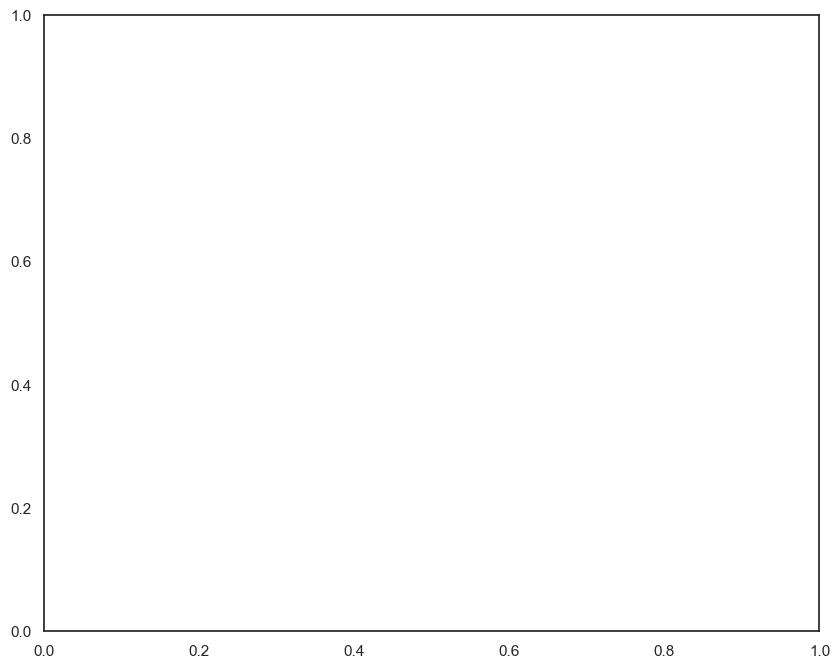

In [ ]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       node_color=list(nx.get_node_attributes(dmn_graph, 'mass').values()),
                       cmap='Greens',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(dmn_graph, pos, labels=nx.get_node_attributes(dmn_graph, 'name'), font_size=8)

# Add a colorbar
cbar = plt.colorbar(nds, fraction=0.035, pad=0.04)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")

plt.box(False)
plt.margins(x=0.3)
plt.show()


In [ ]:
nx.write_graphml(dmn_graph, 'covid_DA_metabolites_network.graphml')

## Correlation network

In [ ]:
def met_corr(datasets):

    # calculate spearman correlation
    corrs = [d.processed_data.iloc[:, :-1].corr(method='spearman').abs() for d in datasets]
    corrs_long = [i.melt(ignore_index=False).reset_index() for i in corrs]

    # average correlation for matching indices
    def combine_columns(row):
        return str(row['index']) + row['variable']

    # Apply the custom function to create a new column 'Combined'
    df['Combined'] = df.apply(combine_columns, axis=1)
    corrs_long_merged = []
    print(corrs_long_merged)
    avg_corr = sum(corrs) / len(corrs)

    return avg_corr
# filter for same columns



In [ ]:
met_corr(studies)

[Empty DataFrame
Columns: [index, variable, value_x, value_y]
Index: [], Empty DataFrame
Columns: [index, variable, value_x, value_y]
Index: [],             index     variable   value_x   value_y
0     CHEBI:16070  CHEBI:16070  1.000000  1.000000
1     CHEBI:16125  CHEBI:16070  0.030297  0.255298
2     CHEBI:16737  CHEBI:16070  0.140844  0.414721
3     CHEBI:75342  CHEBI:16070  0.202653  0.022433
4     CHEBI:69081  CHEBI:16070  0.036152  0.176817
...           ...          ...       ...       ...
4351  CHEBI:17368   CHEBI:6650  0.153252  0.262752
4352  CHEBI:15584   CHEBI:6650  0.610898  0.204759
4353  CHEBI:16000   CHEBI:6650  0.113541  0.019011
4354  CHEBI:15428   CHEBI:6650  0.122486  0.040670
4355   CHEBI:6650   CHEBI:6650  1.000000  1.000000

[4356 rows x 4 columns],            index     variable   value_x   value_y
0    CHEBI:32816  CHEBI:32816  1.000000  1.000000
1    CHEBI:32816  CHEBI:32816  0.000609  1.000000
2    CHEBI:16977  CHEBI:32816  0.329536  0.141810
3    CHEBI:20067 

AssertionError: Gaps in blk ref_locs